# SOLA9101 Workshop Tutorial : Modelling Solar Cells
Friday 17th March 2023.   Ned Ekins-Daukes & Phoebe Pearce

In this tutorial you will learn how to use the opensource [SolCore](www.solcore.solar) and [RayFlare](https://rayflare.readthedocs.io/en/latest/) code to reproduce some of the results presented in our lectures.  You do not need any prior programming experience. The aim of the tutorial is to show you how these models can be configured and give you a starting point should you need to model solar cells in the future.

### Before we start:

- Execute each block of code by pressing the Shift + Return
- Lines preceded with a # are comments and included to help you understand the code.
- Python is fussy about indents so if you change the code, keep the code indented as shown.

## Shockley Queisser Efficiency limit
We will develop a model for an ideal solar cell, working step by step through the problem:

## 1 - Limits to the short-circuit current

In Martin Green's "Red Book", there is a very useful graph that shows the short-circuit current density for a solar cell as a function of band-gap energy.  We will reproduce that graph for AM1.5 here.


### Solar Spectrum

The solar spectrum defines the ultimate current that a solar cell can produce.  First we will plot the AM1.5G solar spectrum $b(\lambda)$ as a spectral irradiance, meaning that the y-axis has units of $W.m^{-2}.nm^{-1}$

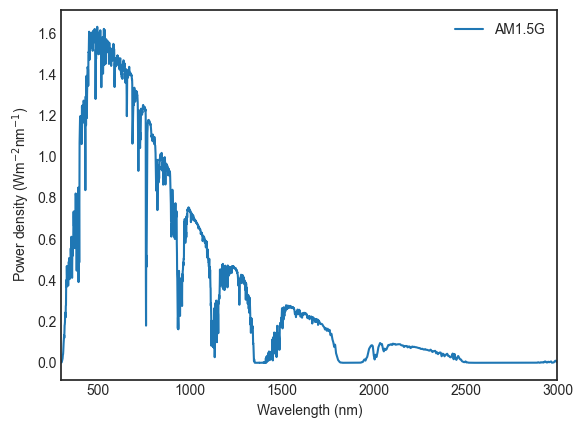

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from solcore.light_source import LightSource

# Setup the AM1.5G solar spectrum
wl = np.linspace(300, 4000, 4000) * 1e-9    #wl contains the x-ordinate in wavelength
am15g = LightSource(source_type='standard', x=wl*1e9, version='AM1.5g')

plt.figure(1)
plt.plot(*am15g.spectrum(wl*1e9), label='AM1.5G')
plt.xlim(300, 3000)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power density (Wm$^{-2}$nm$^{-1}$)')
plt.legend()

Let us now integrate the solar spectrum to provide the total irradiance in units of \[$W.m^{-2}$\].  The code below performs the following operation $\int^{\infty}_{0} b(\lambda) d\lambda$

In [96]:
# Since .spectrum function returns a tuple (x,y) but np.trapz requires data in format (y,x) these are extracted into separate 1D np arrays.
yval = am15g.spectrum()[1]
xval = am15g.spectrum()[0]
integrated_value = np.trapz(yval,xval)  # Perform integration using trapezium rule
b = integrated_value  # Save the integrated power density for the sun for later.
print('b = ', integrated_value)

b =  1000.3974821197136


Let's take the opportunity to learn how to format numbers nicely in Python.  Here we use  the command "%.0f" % to display the value to zero decimal places.

In [97]:
print('b= ',"%.0f" % integrated_value)

b=  1000


### Spectral Photon Flux

To calculate a short-circuit current it is convenient to change the units.  Two changes are necessary :
 1. Since we specify band-gap energies in electron volts (eV) we need to transform the x-axis from nm to eV
2. Photocurrent is proportional to the incident photon flux (number of photons per second) not the irradiance (watts) so we need to convert the y-axis from energy to photon number.

Note: The conversion is performed internally within the software but be aware that because the transformation from wavelength is non-linear, changing the x-axis from nm to eV also changes the y-values of the data. This is known as a Jacobian transformation and discussed in more detail in an article ["Getting the basics right: Jacobian Conversion of Wavelength and Energy Scales for Quantatitive Analysis of Emission Spectra", Journal of Physical Chemistry, 4(19) 3316 (2013)](http://pubs.acs.org/doi/abs/10.1021/jz401508t)

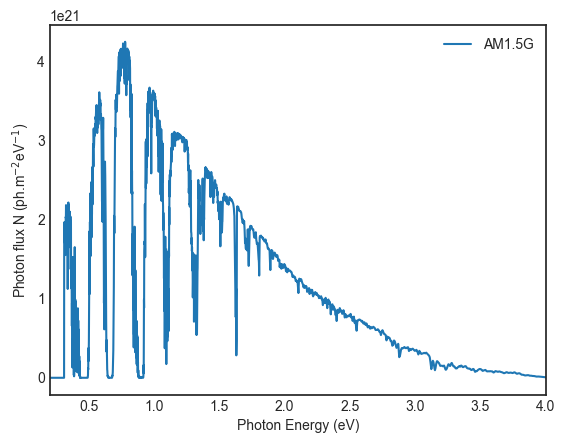

In [98]:
ev = np.linspace(0.02,4,4000)
flux = LightSource(source_type='standard', version='AM1.5g', x=ev, output_units='photon_flux_per_ev')

plt.figure(2)
plt.plot(*flux.spectrum(), label='AM1.5G')
plt.xlim(0.2, 4)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Photon flux N (ph.m$^{-2}$eV$^{-1}$)')
plt.legend()

### Calculating the short-circuit current

Integrating the photon flux can provide an upper limit to the short-circuit current [A.m-2]. We can integrate the spectrum over the entire spectral range using $J_{sc}=q\int_{0}^{\infty}N(E)dE$

In [99]:
q = 1.60217662E-19
yval = flux.spectrum()[1]
xval = flux.spectrum()[0]
yint = q*np.trapz(yval,xval)  # Perform integration using trapezium rule
print("%.0f" % yint)

690


A more useful calculation is to calculate the current that a solar cell would produce with a particular band-gap energy.  To do thie requires a bit more coding, since we now wish to integrate between limits:  $J_{sc}=q\int_{Eg}^{\infty}N(E)dE$

Let's do this for a band-gap of 1.42eV:


In [100]:
q = 1.60217662E-19
eg = 1.42
yval = flux.spectrum()[1]
xval = flux.spectrum()[0]

yval[xval < eg] = 0 # set photon flux to zero for photon energies below the band-gap

yint = q*np.trapz(yval,xval)  # Perform integration using trapezium rule
print("%.0f" % yint)

321


Let's reproduce the Jsc vs Eg graph that is shown on p87 of Martin Green's Solar Cells book:

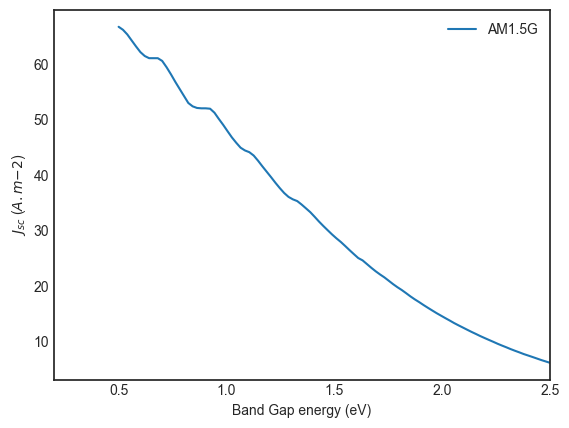

In [101]:
q=1.60217662E-19

def getJsc(eg):
    yval = flux.spectrum()[1]  # Start with the solar spectrum in yval & xval
    xval = flux.spectrum()[0]
    yval[xval < eg] = 0 # set photon flux to zero for photon energies below the band-gap
    return q*np.trapz(yval,xval)  # return the integrated value

eg = np.linspace(0.5,2.5,100)
jsc = np.vectorize(getJsc)(eg)

plt.figure(3)
plt.plot(eg,jsc/10,label='AM1.5G')  # Divide by 10 to convert from A.m^-2 to mA.cm^-2
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('$J_{sc}$ ($A.m{-2}$)')
plt.legend()

## Modelling the voltage of an ideal solar cell as a function of band-gap

In the week 4 tutorial we used an approximation for the radiative limit to $J_0$ given by $J_0=q \frac{2 \pi k T}{c^2 h^3}\left(E_g^2+2 E_g k T+2 k^2 T^2\right) e^{\frac{-E_g}{k T}}$

We can now plot a chart of $J_0$ as a function of band-gap energy using this expression:

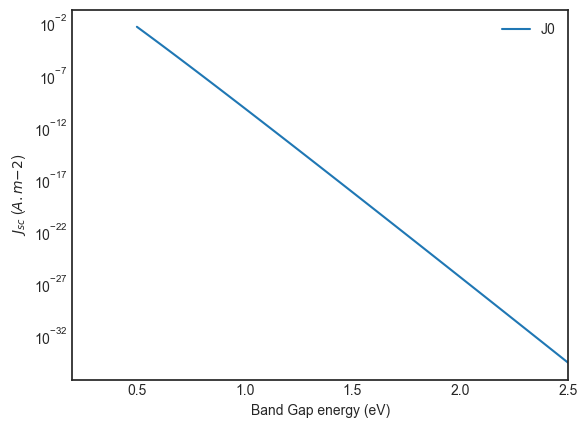

In [102]:
#Define some physical constants:
q = 1.60217662E-19  # electronic charge [C]
k = 1.38064852E-23/q   # Boltzmann constant [eV/K]
h = 6.62607004E-34/q  # Planck constant expressed in [eV.s]
c = 299792458  # Speed of light [m.s^-1]

t = 300  # Perform the calculation for a solar cell at 300K.

#Define a function to return J0 implementing the expression above
def getJ0(eg):
    return k*t*q*(2*np.pi/(c**2*h**3))*(eg**2+2*eg*k*t+2*k**2*t**2)*np.exp(-eg/(k*t))

eg = np.linspace(0.5,2.5,100)
j0 = np.vectorize(getJ0)(eg)

plt.figure(3)
plt.plot(eg,j0,label='J0')  # Divide by 10 to convert from A.m^-2 to mA.cm^-2
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('$J_{sc}$ ($A.m{-2}$)')
plt.yscale("log")
plt.legend()

Let's check the J0 answers for last week's tutorial question:  evaluate getJ0() for Eg=1.42 and Eg=1.88

In [103]:
getJ0(1.42)

1.195457897843886e-17

In [104]:
getJ0(1.88)

3.888154629395649e-25

## Calculating the IV curve

We are now able to calculate the limiting efficiency for a solar cell using the simple Shockley diode expression $J(V)=J_{s c}-J_0\left(e^{\frac{q V}{k T}}-1\right)$.  Let's plot the IV curve for a band-gap of 1.42eV

Text(0, 0.5, 'Current ($mA.cm{-2}$)')

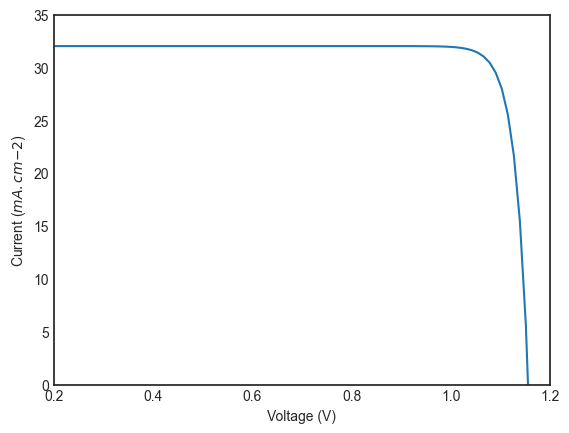

In [105]:
def getJ(v,eg):
    return getJsc(eg) - getJ0(eg)*(np.exp(v/(k*t)) - 1)

eg = 1.42
v = np.linspace(0,1.2,100)
j = np.vectorize(getJ)(v,eg)

plt.figure(3)
plt.plot(v,j/10)  #convert to mA.cm^-2
plt.xlim(0.2, 1.2)
plt.ylim(0,35)
plt.xlabel('Voltage (V)')
plt.ylabel('Current ($mA.cm{-2}$)')

## Calculating the electrical power curve and finding the maximum power

Text(0, 0.5, 'Power ($W.m{-2}$)')

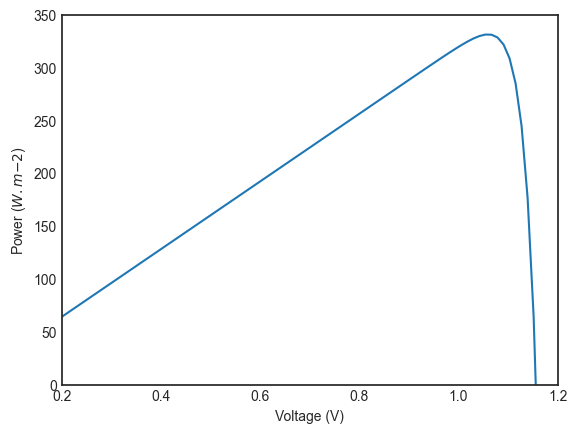

In [106]:
plt.figure(3)
plt.plot(v,v*j)
plt.xlim(0.2, 1.2)
plt.ylim(0,350)
plt.xlabel('Voltage (V)')
plt.ylabel('Power ($W.m{-2}$)')

Define a function to find the maximum power point of the curve above:

In [107]:
def getPmax(eg):
    v = np.linspace(0,eg-0.1,500)
    p = v*np.vectorize(getJ)(v,eg)
    return (np.amax(p))  # The amax command returns the maximum value in the array p

test it out on the curve above

In [108]:
getPmax(1.42)

331.6412760959975

## The Shockley-Queisser efficiency limit

Finally we can calculate the Shockley-Queisser efficiency limit for AM1.5G

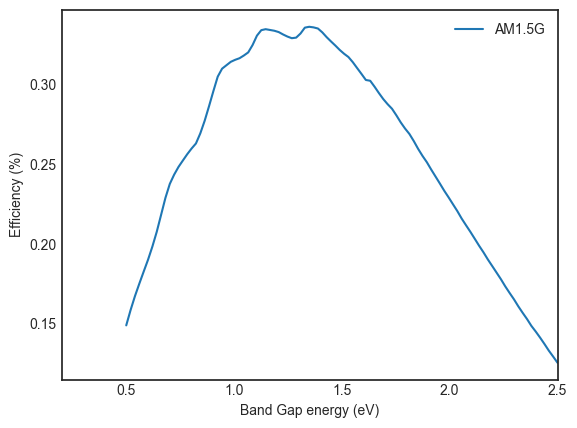

In [109]:
eg = np.linspace(0.5,2.5,100)
p = np.vectorize(getPmax)(eg)

plt.figure(3)
plt.plot(eg,p/b,label='AM1.5G')  # Remember b is the integrated power of the incident sunlight
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('Efficiency (%)')
plt.legend()

The SolCore code has all the functions we have written above built into it.  We worked through this example step by step, but we can calculate the same result using the code below:



-add a DB IV plot for a SJ cell with eg 1.42
-add a SQ plot for the same thing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


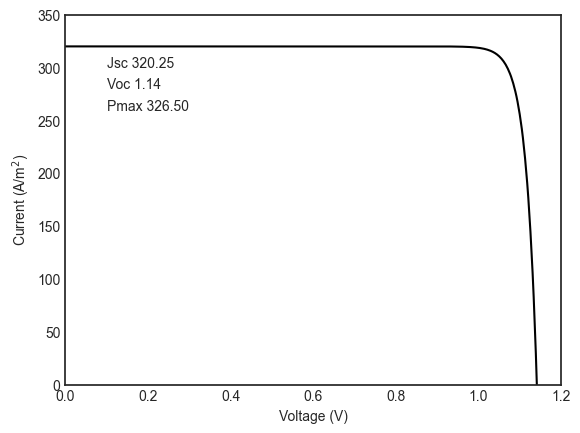

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from solcore.light_source import LightSource
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.structure import Junction

# Load the AM1.5G solar spectrum
wl = np.linspace(300, 4000, 4000) * 1e-9    #wl contains the x-ordinate in wavelength
am15g = LightSource(source_type='standard', x=wl, version='AM1.5g')

eg=1.42
V = np.linspace(0, 1.3, 500)
db_junction = Junction(kind='DB', T=300, Eg=eg, A=1, R_shunt=np.inf, n=1)
my_solar_cell = SolarCell([db_junction], T=300, R_series=0)

solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': 300, 'db_mode': 'top_hat', 'voltages': V, 'light_iv': True,
                                    'internal_voltages': np.linspace(0, 1.3, 400), 'wavelength': wl,
                                    'mpp': True, 'light_source': am15g})

plt.figure(1)
plt.plot(V, my_solar_cell.iv.IV[1], 'k')
plt.ylim(0, 350)
plt.xlim(0, 1.2)
plt.text(0.1,300,f'Jsc {my_solar_cell.iv.Isc:.2f}')
plt.text(0.1,280,f'Voc {my_solar_cell.iv.Voc:.2f}')
plt.text(0.1,260,f'Pmax {my_solar_cell.iv.Pmpp:.2f}')
plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A/m$^2$)')
plt.show()

and the Shockley-Queisser efficiency limit using internal SolCore functions

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solvin

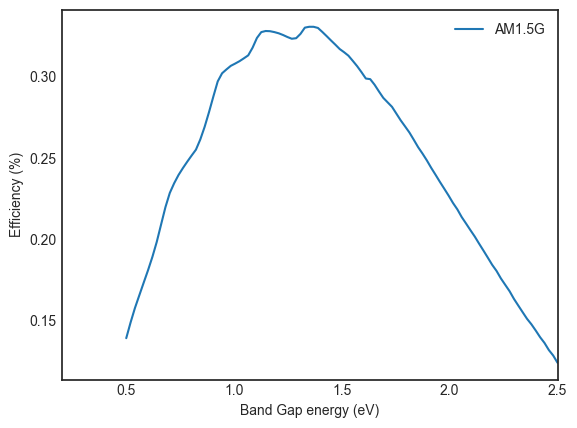

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from solcore.light_source import LightSource
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.structure import Junction

# Load the AM1.5G solar spectrum
wl = np.linspace(300, 4000, 4000) * 1e-9    #wl contains the x-ordinate in wavelength
am15g = LightSource(source_type='standard', x=wl, version='AM1.5g')

def getPmax(eg):
    V = np.linspace(0, eg-0.1, 500)
    db_junction = Junction(kind='DB', T=300, Eg=eg, A=1, R_shunt=np.inf, n=1)
    my_solar_cell = SolarCell([db_junction], T=300, R_series=0)

    solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': 300, 'db_mode': 'top_hat', 'voltages': V, 'light_iv': True, 'wavelength': wl,
                                    'mpp': True, 'light_source': am15g})
    return(my_solar_cell.iv.Pmpp)

eg=np.linspace(0.5,2.5,100)
p=np.vectorize(getPmax)(eg)

plt.figure(3)
plt.plot(eg,p/b,label='AM1.5G')  # Remember b is the integrated power of the incident sunlight
plt.xlim(0.2, 2.5)
plt.xlabel('Band Gap energy (eV)')
plt.ylabel('Efficiency (%)')
plt.legend()